# First level models

## HRF models

Nilearn offers a few different HRF models including the commonly used double-gamma SPM (statistical parametric mapping, 'spm') model and the model shape proposed by G. Glover ('glover'), both allowing the option of adding time and dispersion derivatives. The addition of these derivatives allows to better model any uncertainty in timing information. In addition, an FIR (finite impulse response, 'fir') model of the HRF is also available.

### Set up some parameters for model display

To get an impulse reponse, we simulate a single event occurring at time t=0, with duration 1s.

In [1]:
import numpy as np
frame_times = np.linspace(0, 30, 61)
onset, amplitude, duration = 0., 1., 1.
exp_condition = np.array((onset, duration, amplitude)).reshape(3, 1)

We sample this on a fris for display

In [2]:
stim = np.zeros_like(frame_times)
stim[(frame_times > onset) * (frame_times <= onset + duration)] = amplitude

Now we have to define the candidate hrf models.

In [3]:
hrf_models = [None, 'glover + derivative', 'glover + derivative + dispersion']

### Sample the hrf

/usr/local/anaconda3/envs/sampark/lib/python3.7/site-packages/nilearn/glm/__init__.py:56: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  'It may change in any future release of Nilearn.', FutureWarning)


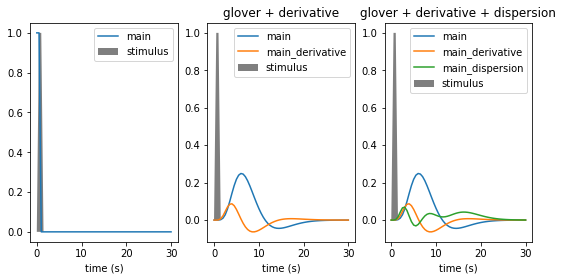

In [4]:
from nilearn.glm.first_level import compute_regressor
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(9, 4))
for i, hrf_model in enumerate(hrf_models):
    # obtain the signal of interest by convolution
    signal, name = compute_regressor(
        exp_condition, hrf_model, frame_times, con_id='main',
        oversampling=16)

    # plot this
    plt.subplot(1, 3, i + 1)
    plt.fill(frame_times, stim, 'k', alpha=.5, label='stimulus')
    for j in range(signal.shape[1]):
        plt.plot(frame_times, signal.T[j], label=name[j])
    plt.xlabel('time (s)')
    plt.legend(loc=1)
    plt.title(hrf_model)

# adjust the plot
plt.subplots_adjust(bottom=.12)
plt.show()

## Design matrix: event-based and time series-based

### Event-based

To create an event-based design matrix, information about the trial type, onset time and duration of the events in the experiment are necessary. This can be provided by the user, or be part of the dataset if using a BIDS-compatible dataset or one of the nilearn dataset fetcher functions like nilearn.datasets.fetch_spm_multimodal_fmri, nilearn.datasets.fetch_language_localizer_demo_dataset, etc.

Refer to the examples below for usage under the different scenarios:

* User-defined: Examples of design matrices

* Using an OpenNEURO dataset: First level analysis of a complete BIDS dataset from openneuro

* Uing nilearn fetcher functions: Single-subject data (two sessions) in native space

To ascertain that the sequence of events provided to the first level model is accurate, Nilearn provides an event visualization function called nilearn.plotting.plot_event. Sample usage for this is available in Decoding of a dataset after GLM fit for signal extraction.

Once the events are defined, the design matrix is created using the nilearn.glm.first_level.make_first_level_design_matrix function:

### Examples of design matrices

Three examples of design matrices specification and computation for first-level fMRI data analysis (event-related design, block design, FIR design).

This examples requires matplotlib.

In [5]:
try:
    import matplotlib.pyplot as plt
except ImportError:
    raise RuntimeError("This script needs the matplotlib library")

#### Define parameters

At first, we define parameters related to the images acquisition.

In [6]:
import numpy as np
tr = 1.0  # repetition time is 1 second
n_scans = 128  # the acquisition comprises 128 scans
frame_times = np.arange(n_scans) * tr  # here are the correspoding frame times
frame_times.shape

(128,)

Then we define parameters related to the experimental design.

In [7]:
# these are the types of the different trials
conditions = ['c0', 'c0', 'c0', 'c1', 'c1', 'c1', 'c3', 'c3', 'c3']
duration = [1., 1., 1., 1., 1., 1., 1., 1., 1.]
# these are the corresponding onset times
onsets = [30., 70., 100., 10., 30., 90., 30., 40., 60.]
# Next, we simulate 6 motion parameters jointly observed with fMRI acquisitions
motion = np.cumsum(np.random.randn(n_scans, 6), 0)
# The 6 parameters correspond to three translations and three
# rotations describing rigid body motion
add_reg_names = ['tx', 'ty', 'tz', 'rx', 'ry', 'rz']

motion.shape

(128, 6)

#### Create design matrices

The same parameters allow us to obtain a variety of design matrices. We first create an events object.

In [8]:
import pandas as pd
events = pd.DataFrame({'trial_type': conditions, 'onset': onsets,
                       'duration': duration})
events.shape

(9, 3)

We sample the events into a design matrix, also including additional regressors.

In [9]:
hrf_model = 'glover'
from nilearn.glm.first_level import make_first_level_design_matrix
X1 = make_first_level_design_matrix(
    frame_times, events, drift_model='polynomial', drift_order=3,
    add_regs=motion, add_reg_names=add_reg_names, hrf_model=hrf_model)
X1.shape

(128, 13)

Now we compute a block design matrix. We add duration to create the blocks. For this we first define an event structure that includes the duration parameter.

In [10]:
duration = 7. * np.ones(len(conditions))
events = pd.DataFrame({'trial_type': conditions, 'onset': onsets,
                       'duration': duration})
events.shape

(9, 3)

Then we sample the design matrix.

In [11]:
X2 = make_first_level_design_matrix(frame_times, events,
                                    drift_model='polynomial', drift_order=3,
                                    hrf_model=hrf_model)
X2.shape

(128, 7)

Finally we compute a FIR model

In [12]:
events = pd.DataFrame({'trial_type': conditions, 'onset': onsets,
                       'duration': duration})
events.shape

(9, 3)

In [13]:
# hrf_model = 'FIR'
X3 = make_first_level_design_matrix(frame_times, events, hrf_model='fir', fir_delays=np.arange(1, 6),
                                    drift_model='polynomial', drift_order=3,
                                    add_regs=np.array(motion), add_reg_names=add_reg_names)
X3.shape

(128, 25)

Here are the three designs side by side.

/usr/local/anaconda3/envs/sampark/lib/python3.7/site-packages/nilearn/datasets/__init__.py:90: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


Text(0.5, 1.0, 'FIR design matrix')

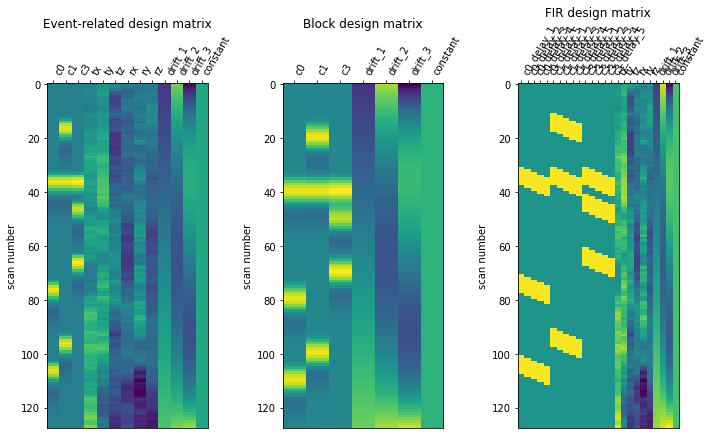

In [14]:
from nilearn.plotting import plot_design_matrix
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(10, 6), nrows=1, ncols=3)
plot_design_matrix(X1, ax=ax1)
ax1.set_title('Event-related design matrix', fontsize=12)
plot_design_matrix(X2, ax=ax2)
ax2.set_title('Block design matrix', fontsize=12)
plot_design_matrix(X3, ax=ax3)
ax3.set_title('FIR design matrix', fontsize=12)

- - -

# GA data

In [15]:
import numpy as np
import pandas as pd
from os.path import join
# import getpass
from nilearn.plotting import plot_design_matrix
# from nilearn import image as niimg
# import nilearn.glm.first_level as niglm
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.glm.first_level import compute_regressor

script_dir = '.'
root_dir = join('/Volumes','GoogleDrive','내 드라이브','GA')

preproc_dir = root_dir + '/fMRI_data/preproc_data'
reg_dir = root_dir + '/behav_data/regressors'

subj = '01'
visit = 'early'
run = 1

gg = 'GA' if visit=='early' else('GB' if visit=='late' else 'invalid')

tr = .46  # repetition time is 0.46 second
n_scans = 1096  # the acquisition comprises 1096 scans
frame_times = np.arange(n_scans) * tr  # here are the correspoding frame times

## pb02

## Regressors

motion regressors

In [16]:
motion_headers = ['roll', 'pitch', 'yaw', 'dS', 'dL', 'dP']
motions = []
with open(join(preproc_dir,subj,'motion_demean.%s%s.r%02d.1D'%(gg,subj,run))) as fr:
    for line in fr:
        motions.append((np.array(line.strip().split(' ')).astype(float)))
motions = np.array(motions)
motions.shape

(1096, 6)

MO regressor

개념: early 와 late 에서 Movement 와 Reward 의 correlation 이 너무 높아서 (움직임이 많으면 답을 찾고 있는 상황/움직임이 적으면 답을 맞추고 있는 상황), overall movement 를 regress out 하기 위함

In [17]:
MO = []
with open(join(reg_dir,'displacement','%s%s.onset.AM1.disp.ideal.run1to3.xmat.1D'%(gg,subj))) as fr:
    for line in fr:
        if line[0]==' ':
            MO.append(line.strip().split(' ')[-1])
MO = np.array(MO).astype(float)[1096*(run-1):1096*(run)]
MO = MO-MO.mean()
MO.shape

(1096,)

target ID

In [18]:
conditions = []
with open(join(script_dir,'targetID.txt')) as fr:
    for line in fr:
        conditions.append(int(line.strip()))
conditions = np.array(conditions[:97])
conditions.shape

(97,)

onset time of targets

In [19]:
temp = {}
for target in [1, 5, 21, 25]:
    with open(join(reg_dir,'4targets','%s%s.onset.prac.target%d.txt'%(gg,subj,target))) as fr:
        for rr, line in enumerate(fr):
            temp[rr+1, target] = np.array(line.strip().split(' ')).astype(float)
            
onsets = np.sort(np.concatenate([temp[run, target] for target in [1,5,21,25]]))
onsets.shape

(97,)

duration time for each target to be displayed

In [20]:
durations = np.array([5 for i in range(97)])
durations.shape

(97,)

events in each trial

In [21]:
events = pd.DataFrame({'trial_type': conditions, 'onset': onsets,
                       'duration': durations})
events.shape

(97, 3)

In [22]:
events

,trial_type,onset,duration
0,1,2.043,5
1,5,7.068,5
2,25,12.065,5
3,21,17.091,5
4,1,22.098,5
...,...,...,...
92,25,462.079,5
93,1,467.078,5
94,21,472.082,5
95,5,477.081,5


## Design Matrix

In [23]:
motion_regs = np.array([list(a)+[b] for a, b in zip(motions, MO)])
motion_regs.shape

(1096, 7)

1) Event-related design matrix

<AxesSubplot:label='conditions', ylabel='scan number'>

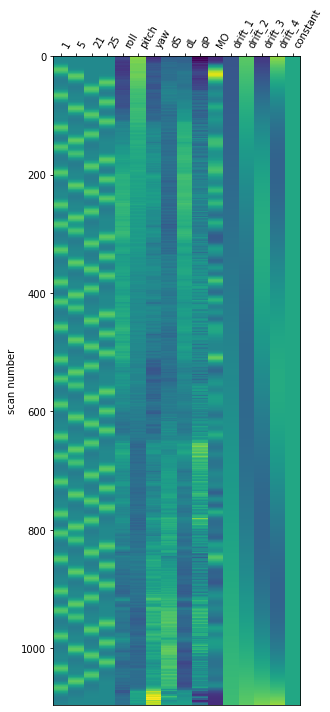

In [24]:
X_glover = make_first_level_design_matrix(
    frame_times, events, hrf_model = 'glover'
    , drift_model = 'polynomial', drift_order = 4
    , add_regs= motion_regs, add_reg_names = motion_headers+['MO'])
plot_design_matrix(X_glover)

2) FIR design matrix

In [25]:
X_fir = make_first_level_design_matrix(
    frame_times, events, hrf_model = 'fir', fir_delays=np.arange(1,4)
    , drift_model = 'polynomial', drift_order = 4
    , add_regs= motion_regs, add_reg_names = motion_headers)
plot_design_matrix(X_fir)

ValueError: Incorrect number of additional regressor names was provided(6 provided, 7 expected

### LSS

hand-maded LSS

In [ ]:
events_LSS = events
events_LSS['trial_type'] = range(97)

In [ ]:
temp = make_first_level_design_matrix(
    frame_times, events_LSS, drift_model='polynomial', drift_order=4
    , add_regs=motion_regs, add_reg_names=motion_headers+['MO'], hrf_model='glover')

In [ ]:
X_LSS = pd.DataFrame(index=frame_times, columns=['constant','drift_1','drift_2','drift_3','drift_4']+list(range(97))+motion_headers+['MO'])
for col in temp.columns:
    X_LSS[col] = temp[col]

In [ ]:
plot_design_matrix(X_LSS)

Compare it with a design matrix which is from 3dLSS

In [ ]:
col_header = ['Run#%d#Pol#%d'%(run,pol) for pol in range(5)] + ['beta#%02d'%k for k in range(97)] + ['roll', 'pitch', 'yaw', 'dS', 'dL', 'dP', 'MO']
temp = []
with open(join(preproc_dir,subj,'X.xmatLSS.MO.shortdur.%s%s.r%02d.1D'%(gg,subj,run))) as fr:
    for line in fr:
        if line[0]==' ':
            temp.append(np.array(line.strip().split(' ')).astype(float))
X_3dLSS = pd.DataFrame(temp, columns=col_header, index=frame_times)

In [ ]:
plot_design_matrix(X_3dLSS)